In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_absolute_error



# Predobrada podataka i filtriranje

In [66]:
# Učitavanje svih sheetova i spajanje u jedan DataFrame
file_path = 'Data_2015-2021_student.xlsx'
sheets = pd.read_excel(file_path, sheet_name=None)  # Učitaj sve sheetove

# Priprema praznog DataFramea za spajanje svih podataka
data_all_years = pd.DataFrame()

# Iteracija kroz svaki sheet i dodavanje stupca za godinu ocjenjivanja
for sheet_name, df in sheets.items():
    df['Godina_ocjenjivanja'] = int(sheet_name) 
    data_all_years = pd.concat([data_all_years, df], ignore_index=True)

# Pretvorba GODINA_BERBE u int
data_all_years['GODINA_BERBE'] = data_all_years['GODINA_BERBE'].astype(str).str.replace(r'\D', '', regex=True)
data_all_years = data_all_years[data_all_years['GODINA_BERBE'] != '']
data_all_years['GODINA_BERBE'] = data_all_years['GODINA_BERBE'].astype(int)

# Zamjena crtica '-' s NaN vrijednostima
data_all_years['SORTE_MANJE_OD_85'] = data_all_years['SORTE_MANJE_OD_85'].replace('-', np.nan)
data_all_years['SORTE_VISE_OD_85'] = data_all_years['SORTE_VISE_OD_85'].replace('-', np.nan)

#Pretvaranje `L2_ocjena` u numerički format, ne-numeričke vrijednosti postaju NaN
data_all_years['L2_OCJENA'] = pd.to_numeric(data_all_years['L2_OCJENA'], errors='coerce')

# Dodavanje stupca Starost_vina
data_all_years['Starost_vina'] = data_all_years['Godina_ocjenjivanja'] - data_all_years['GODINA_BERBE']

# Filtriranje podataka za 100% čista vina koja imaju ocjenu
data_clean_wines = data_all_years[
    data_all_years['SORTE_MANJE_OD_85'].isna() & 
    data_all_years['SORTE_VISE_OD_85'].notna() & 
    data_all_years['L2_OCJENA'].notna()
]

#param_cols = data_clean_wines.columns[8:23]
param_columns = ['Ekstrakt_bez_reducirajućih_šećera_gL',
       'Ekstrakt_bez_reducirajućih_šećera_i_nehlapive_kiselosti_gL',
       'Hlapiva_kiselost_kao_octena_gL', 'Nehlapiva_kiselost_kao_vinska_gL',
       'Pepeo_gL', 'pH', 'Reducirajući_šećeri_gL', 'Relativna_gustoća',
       'Slobodni_sumporni_dioksid', 'Stvarni_alkohol_vol',
       'Stvarni_alkohol_gL', 'Ukupna_kiselost_kao_vinska_gL',
       'Ukupni alkohol % vol', 'Ukupni ekstrakt suhi g/L',
       'Ukupni sumporni dioksid mg/L'] 

# Uklanjanje redaka s duplikatima
data_clean_wines = data_clean_wines.drop_duplicates()   #17081
#data_clean_wines = data_clean_wines.drop_duplicates(subset=data_clean_wines.columns[8:23])  # ako je 8:23 (samo parametri) onda ima 15850, ako je 7:23 (l2 ocjena) onda je 16559, sto znaci da je nekima isti parametri ali razlicita ocjena

#uklanjanje redaka s nedostajucim vrijednostima parametara
data_clean_wines = data_clean_wines.dropna(subset=param_columns, how='any')

# Provjera rezultata
#data_clean_wines.to_excel('clean_wines.xlsx', index=False, engine='openpyxl')
#print(f'Broj redaka nakon filtriranja: {len(data_clean_wines)}')

# Izbacivanje grešaka u ocitanjima
data_clean_wines = data_clean_wines[data_clean_wines['Reducirajući_šećeri_gL'] != 10000]
data_clean_wines = data_clean_wines[data_clean_wines['Relativna_gustoća'] != 5.2]
data_clean_wines = data_clean_wines[data_clean_wines['Nehlapiva_kiselost_kao_vinska_gL'] != 82]

# Statistička analiza svih vina

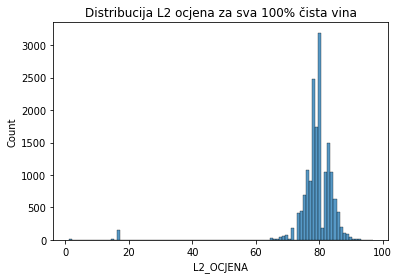

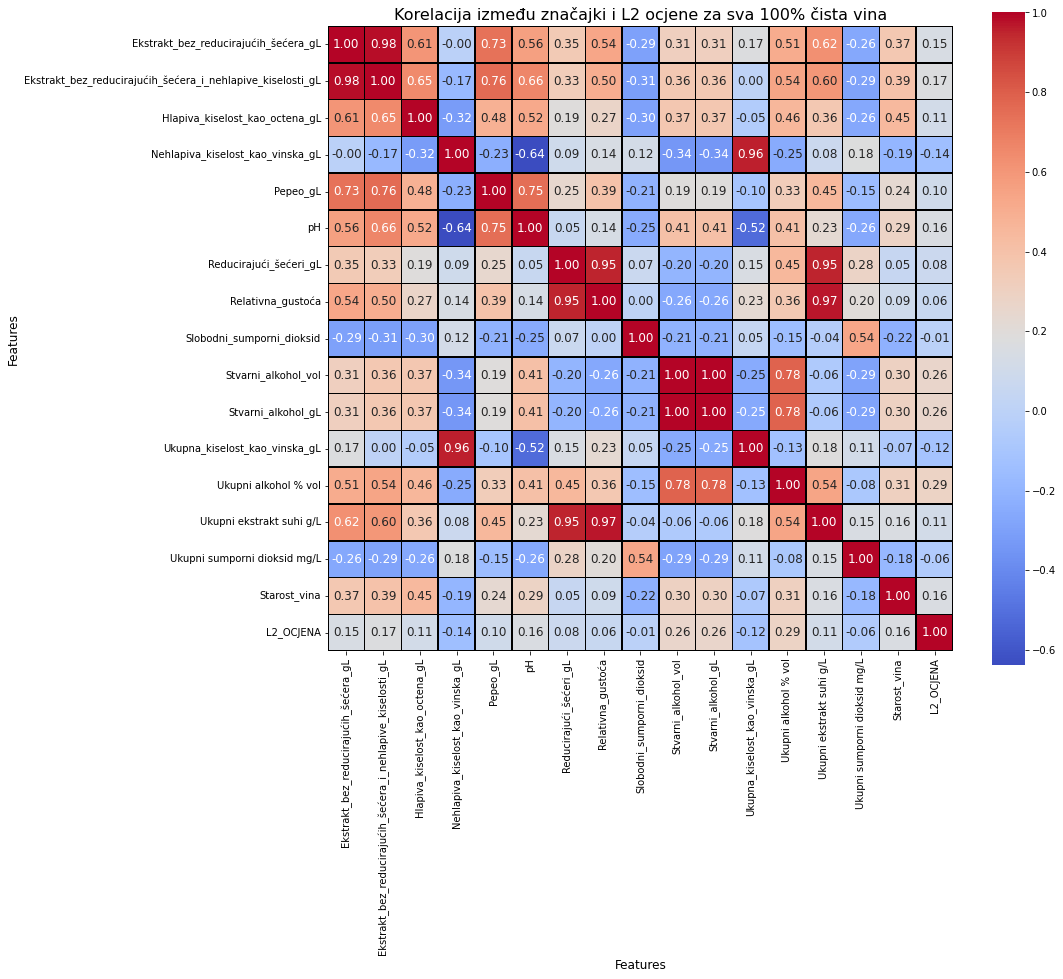

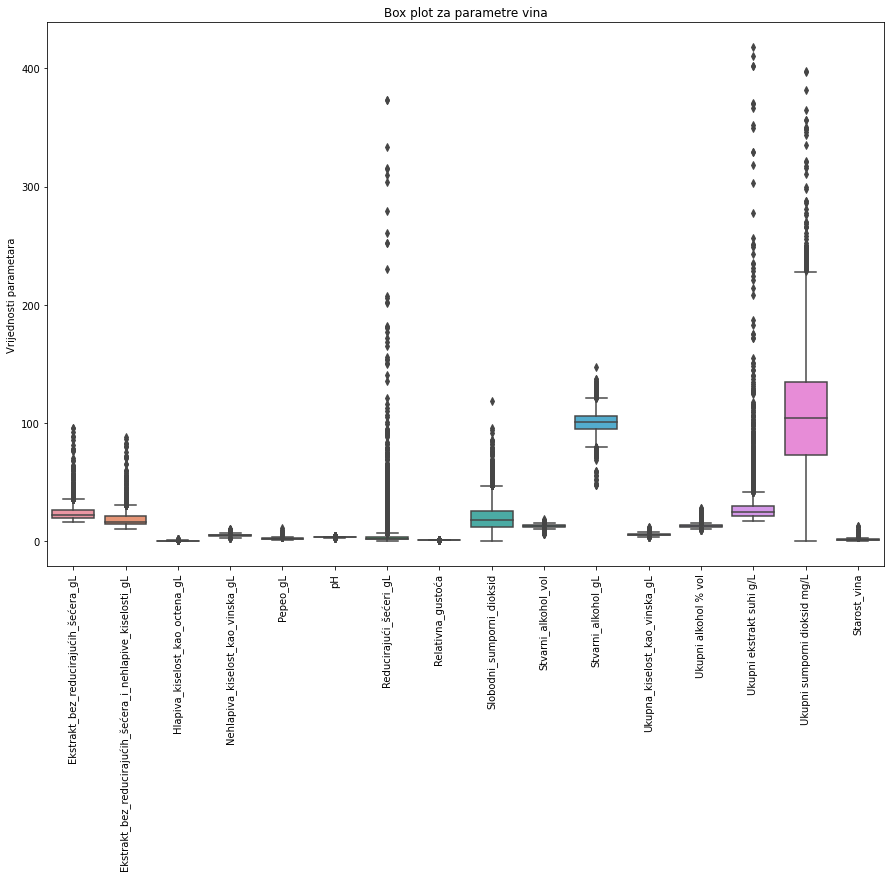

In [67]:
sns.histplot(data_clean_wines['L2_OCJENA'], bins=100)
plt.title('Distribucija L2 ocjena za sva 100% čista vina')
plt.show()

correlation_matrix = data_clean_wines[param_columns + ['Starost_vina', 'L2_OCJENA']].corr()
plt.figure(figsize=(14, 12)) 
# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,           # Show annotations
    cmap='coolwarm',      # Color map
    fmt='.2f',            # Format for annotations
    annot_kws={'size': 12},  # Font size for annotations
    linewidths=0.5,       # Width of the lines separating cells
    linecolor='black',    # Color of the lines separating cells
    square=True           # Make cells square-shaped
)
plt.title('Korelacija između značajki i L2 ocjene za sva 100% čista vina', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

# Boxplot parametara
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_clean_wines[param_columns + ['Starost_vina']])
plt.xticks(rotation=90)
plt.ylabel('Vrijednosti parametara')
plt.title('Box plot za parametre vina')
plt.show()

max_gustoca = data_clean_wines['Relativna_gustoća'].max()
max_kiselost = data_clean_wines['Nehlapiva_kiselost_kao_vinska_gL'].max()

### Parametri vina imaju drukcije mjere pa bi bilo pametno da ih normaliziramo

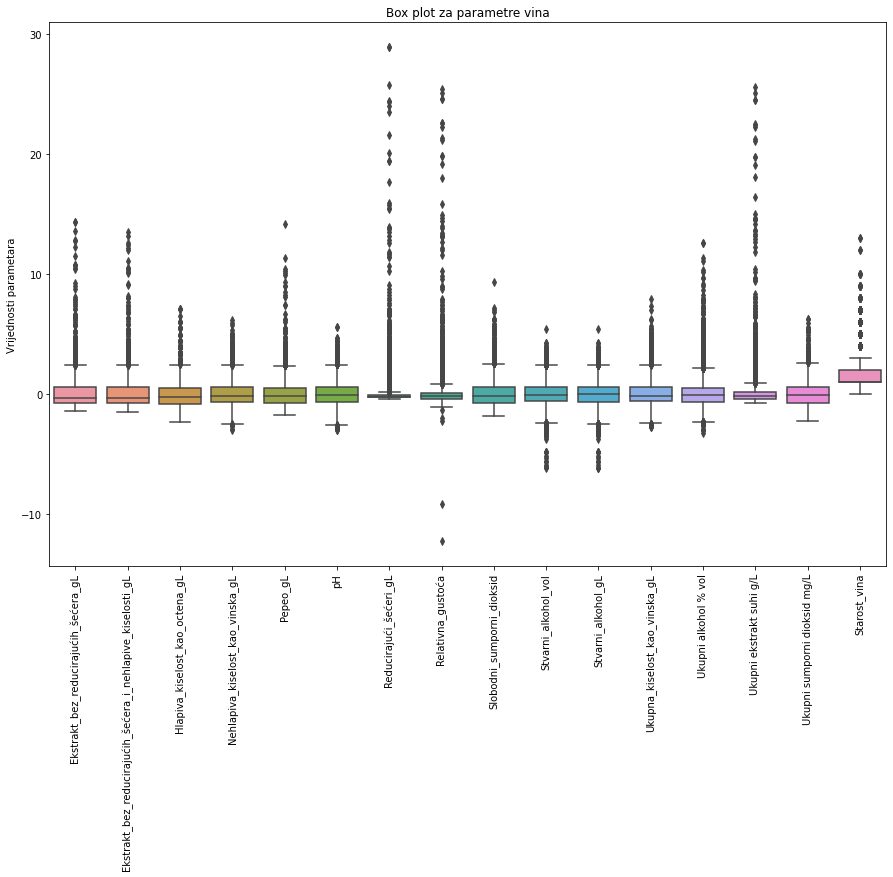

In [68]:
scaler = StandardScaler()
# Skaliranje samo odabranih parametara
data_clean_wines[param_columns] = scaler.fit_transform(data_clean_wines[param_columns])

# Boxplot parametara
plt.figure(figsize=(15, 10))
sns.boxplot(data=data_clean_wines[param_columns + ['Starost_vina']])
plt.xticks(rotation=90)
plt.ylabel('Vrijednosti parametara')
plt.title('Box plot za parametre vina')
plt.show()

In [69]:
data_clean_wines.to_excel('clean_wines.xlsx', index=False, engine='openpyxl')

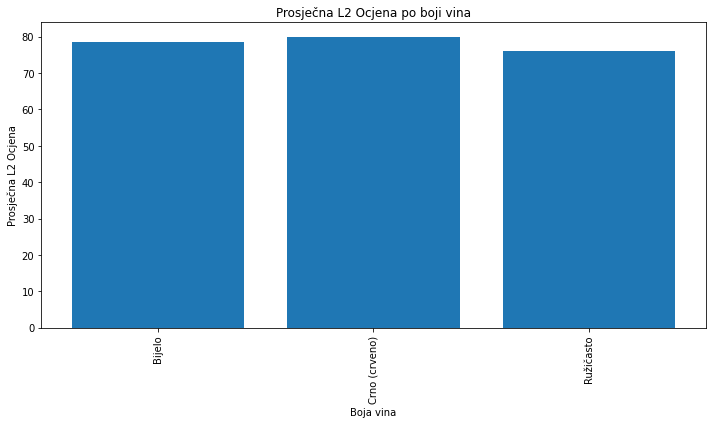

In [70]:
average_scores = data_clean_wines.groupby('BOJA')['L2_OCJENA'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_scores['BOJA'].astype(str), average_scores['L2_OCJENA'])
plt.xlabel('Boja vina')
plt.ylabel('Prosječna L2 Ocjena')
plt.title('Prosječna L2 Ocjena po boji vina')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

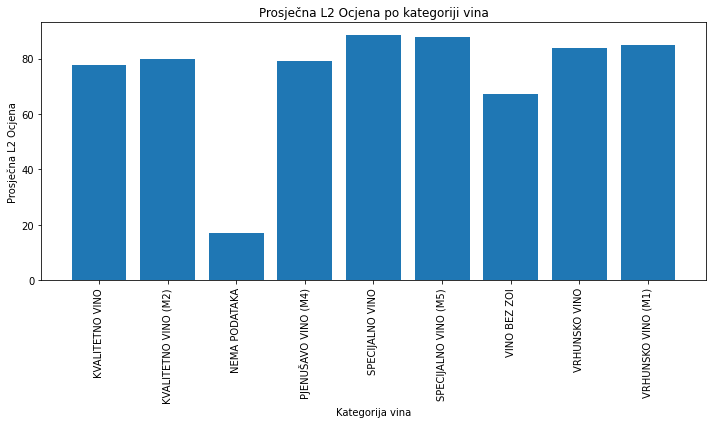

In [71]:
average_scores = data_clean_wines.groupby('SKRACENA_KATEGORIJA')['L2_OCJENA'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_scores['SKRACENA_KATEGORIJA'].astype(str), average_scores['L2_OCJENA'])
plt.xlabel('Kategorija vina')
plt.ylabel('Prosječna L2 Ocjena')
plt.title('Prosječna L2 Ocjena po kategoriji vina')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

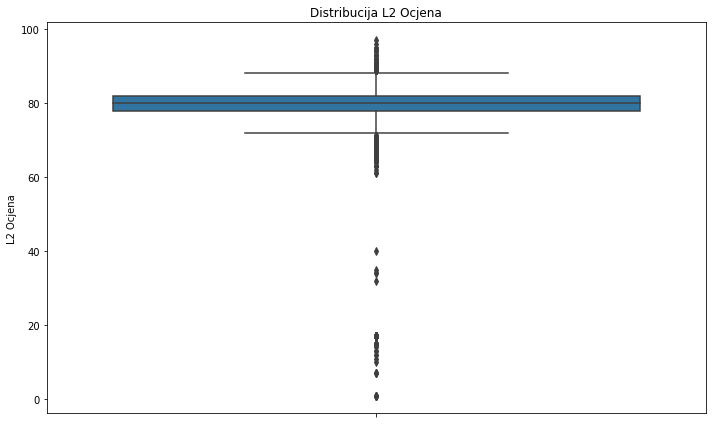

In [72]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='L2_OCJENA', data=data_clean_wines)
plt.ylabel('L2 Ocjena')
plt.title('Distribucija L2 Ocjena')
plt.tight_layout()
plt.show()

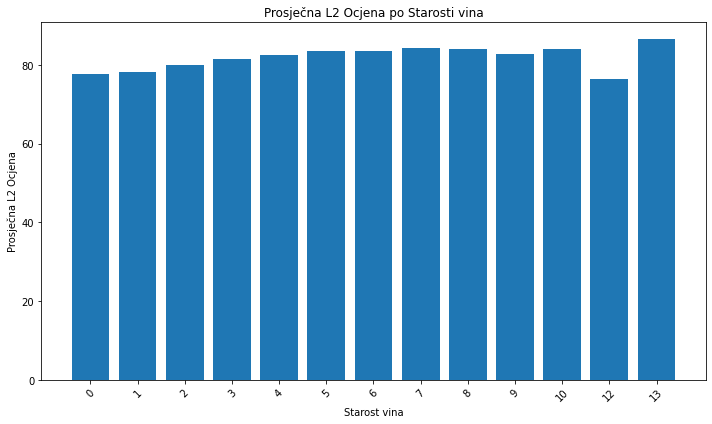

In [73]:
average_scores = data_clean_wines.groupby('Starost_vina')['L2_OCJENA'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_scores['Starost_vina'].astype(str), average_scores['L2_OCJENA'])
plt.xlabel('Starost vina')
plt.ylabel('Prosječna L2 Ocjena')
plt.title('Prosječna L2 Ocjena po Starosti vina')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

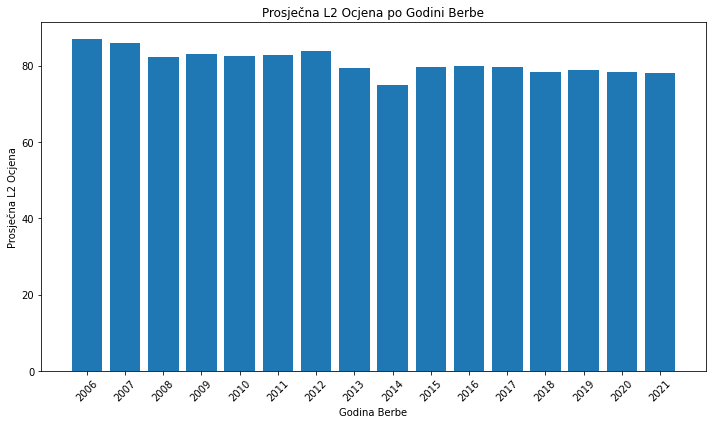

In [74]:
average_scores = data_clean_wines.groupby('GODINA_BERBE')['L2_OCJENA'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(average_scores['GODINA_BERBE'].astype(str), average_scores['L2_OCJENA'])
plt.xlabel('Godina Berbe')
plt.ylabel('Prosječna L2 Ocjena')
plt.title('Prosječna L2 Ocjena po Godini Berbe')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


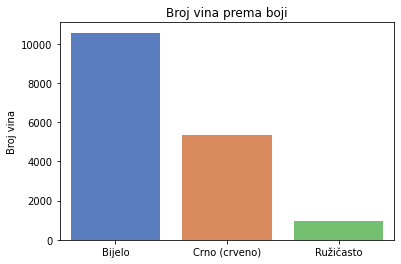

In [75]:
# Step 1: Get the count of each unique entity in the 'BOJA' column
wine_color_counts = data_clean_wines['BOJA'].value_counts()

# Step 2: Plot the counts
plt.figure(figsize=(6,4))  # Adjust figure size if needed
sns.barplot(x=wine_color_counts.index, y=wine_color_counts.values, palette='muted')

# Step 3: Customize the plot
plt.title('Broj vina prema boji')
plt.ylabel('Broj vina')

# Show the plot
plt.show()

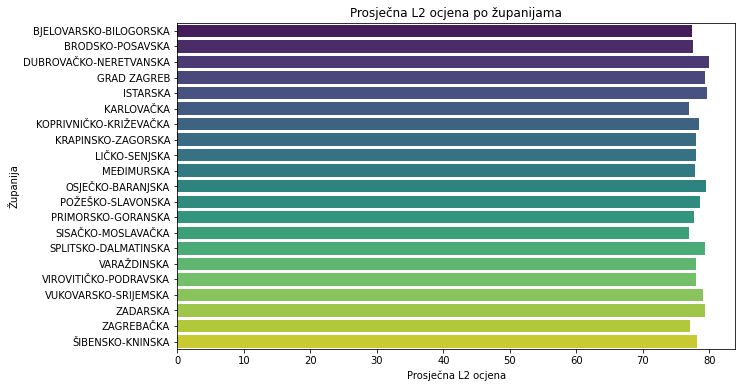

In [76]:
avg_grade_by_county = data_clean_wines.groupby('ZUPANIJA')['L2_OCJENA'].mean()

# Step 2: Plot the average L2 grade by county
plt.figure(figsize=(10,6))  # Set figure size
sns.barplot(x=avg_grade_by_county.values, y=avg_grade_by_county.index, palette='viridis')

# Step 3: Customize the plot
plt.title('Prosječna L2 ocjena po županijama')
plt.xlabel('Prosječna L2 ocjena')
plt.ylabel('Županija')

# Show the plot
plt.show()


# 100% GRAŠEVINA

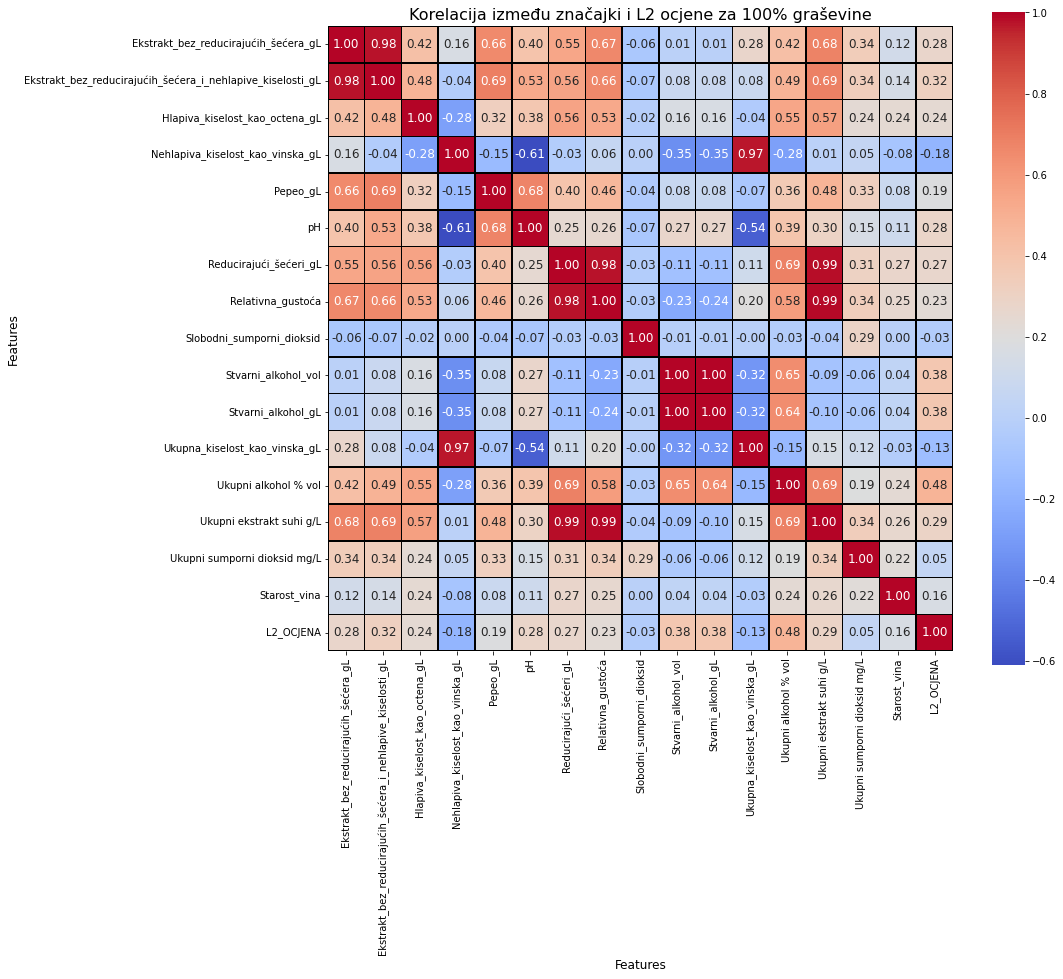

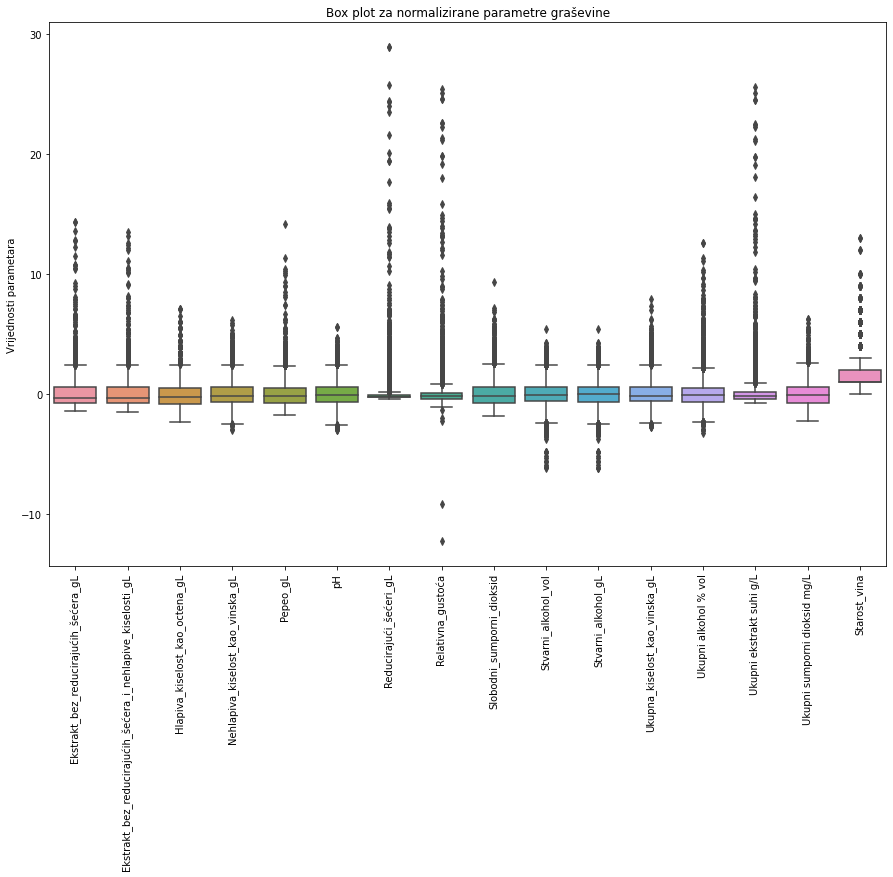

In [104]:
# Filtriranje podataka samo za 100% Graševinu
data_grasevina = data_clean_wines[data_clean_wines['SORTE_VISE_OD_85'].str.contains('graševina', case=False)]
data_grasevina = data_grasevina[data_grasevina['L2_OCJENA'] >= 60]
data_grasevina.to_excel('data_grasevina.xlsx', index=False, engine='openpyxl')

# Korelacija između značajki i L2 ocjene za 100% grasevinu
correlation_matrix = data_grasevina[param_columns + ['Starost_vina', 'L2_OCJENA']].corr()
plt.figure(figsize=(14, 12))  # Adjust width and height as needed
# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,           # Show annotations
    cmap='coolwarm',      # Color map
    fmt='.2f',            # Format for annotations
    annot_kws={'size': 12},  # Font size for annotations
    linewidths=0.5,       # Width of the lines separating cells
    linecolor='black',    # Color of the lines separating cells
    square=True           # Make cells square-shaped
)
plt.title('Korelacija između značajki i L2 ocjene za 100% graševine', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

plt.figure(figsize=(15, 10))
sns.boxplot(data=data_clean_wines[param_columns + ['Starost_vina']])
plt.xticks(rotation=90)
plt.ylabel('Vrijednosti parametara')
plt.title('Box plot za normalizirane parametre graševine')
plt.show()


In [97]:
# Definiranje značajki i ciljne varijable
X = data_grasevina[param_columns + ['Starost_vina']]
y = data_grasevina['L2_OCJENA'].astype(float)

### Definirajmo našu neuronsku mrežu

In [99]:
def fcnn_model(input_dim):
    model = Sequential()
    
    # Input layer
    model.add(Dense(16, input_dim=input_dim, use_bias=False))  # Equivalent to self.input layer
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # First hidden layer
    model.add(Dense(32, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Second hidden layer
    model.add(Dense(20, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Third hidden layer
    model.add(Dense(16, use_bias=False))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # Output layer
    model.add(Dense(1))  # Output layer for regression

    return model


In [155]:
model = fcnn_model(16)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error', 
              metrics=['mae']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train,
                    epochs=60,  
                    batch_size=32, 
                    validation_split=0.2, 
                    verbose=1)

Epoch 1/60
50/50 [==============================] - 1s 7ms/step - loss: 6181.8950 - mae: 78.5501 - val_loss: 6144.1396 - val_mae: 78.3041
Epoch 2/60
50/50 [==============================] - 0s 3ms/step - loss: 6058.2252 - mae: 77.7517 - val_loss: 6080.6279 - val_mae: 77.8958
Epoch 3/60
50/50 [==============================] - 0s 3ms/step - loss: 5953.9743 - mae: 77.0746 - val_loss: 5976.4995 - val_mae: 77.2240
Epoch 4/60
50/50 [==============================] - 0s 2ms/step - loss: 5834.8730 - mae: 76.3015 - val_loss: 5833.5562 - val_mae: 76.2947
Epoch 5/60
50/50 [==============================] - 0s 2ms/step - loss: 5710.0963 - mae: 75.4717 - val_loss: 5666.6973 - val_mae: 75.1955
Epoch 6/60
50/50 [==============================] - 0s 3ms/step - loss: 5585.7454 - mae: 74.6489 - val_loss: 5482.0732 - val_mae: 73.9580
Epoch 7/60
50/50 [==============================] - 0s 2ms/step - loss: 5435.7403 - mae: 73.6461 - val_loss: 5320.1343 - val_mae: 72.8594
Epoch 8/60
50/50 [================

In [192]:
# Evaluate the model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

# Convert predictions and actual values to 1D arrays
y_test = y_test.values
y_pred = y_pred.flatten()

# Create a DataFrame for plotting
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, color='blue', s=100, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()
"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
"""
# Bez oversampling y
#MAE (3.4573): Prosječne pogreške modelovih predikcija, s obzirom na skalu ocjena od 1 do 100 
#R^2 (0.9270030018977075): Ova vrijednost pokazuje da vaš model objašnjava 92.7% varijance u ocjenama kvalitete vina, što ukazuje na dobro uklapanje modela u podatke.
#MSE (42.7939): Ova vrijednost pokazuje prosječni kvadratni razmak između predviđenih i stvarnih vrijednosti

# SA skaliranjem y (l2_ocjena)
#R-squared: 0.9531614777301454
#Test Loss (MSE): 0.0474, Test MAE: 0.1044

R-squared: 0.05174998315215629
MSE: 11.9868
MAE: 2.5442
RMSE: 3.4622
Accuracy 100*(1-rmse/40): 91.3445%


AttributeError: 'numpy.ndarray' object has no attribute 'values'

R-squared: 0.26250342333850885
MSE: 9.3227
MAE: 2.2581
RMSE: 3.0533
Accuracy 100*(1-rmse/40): 92.3667%


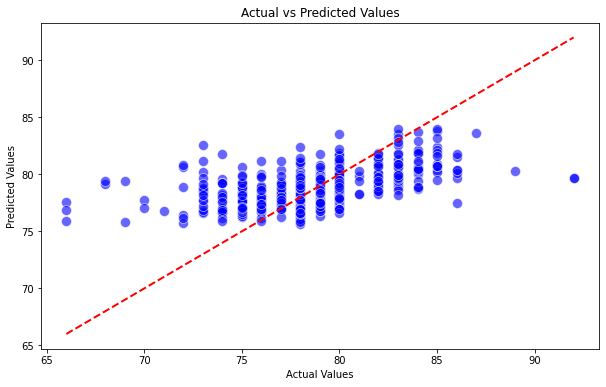

In [176]:
from sklearn.svm import SVR

# Define the model
svr_model = SVR(kernel='rbf')  # Radial basis function kernel

# Train the model
svr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = svr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

# Create a DataFrame for plotting
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, color='blue', s=100, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

R-squared: 0.2766389805668227
MSE: 9.1440
MAE: 2.2989
RMSE: 3.0239
Accuracy 100*(1-rmse/40): 92.4402%


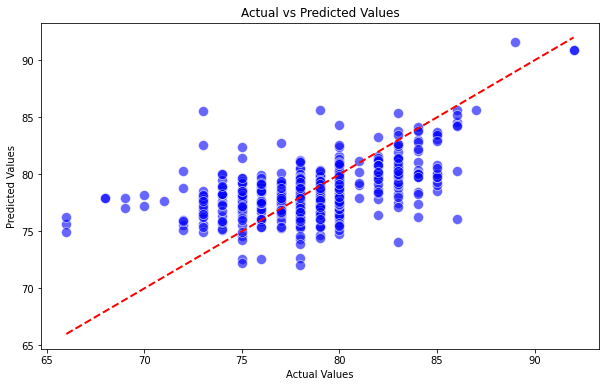

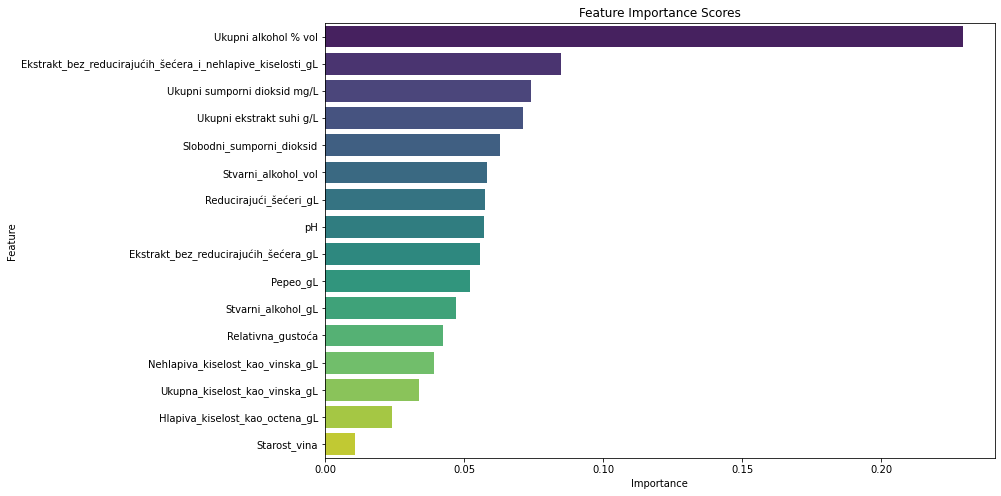

In [203]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions
y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

# Create a DataFrame for plotting
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, color='blue', s=100, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

# Get feature importance scores
importances = rf_regressor.feature_importances_

# Create a DataFrame for plotting
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Scores')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [178]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define the model
lr_model = LinearRegression()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

R-squared: 0.2584680919310365
MSE: 9.3737
MAE: 2.3179
RMSE: 3.0616
Accuracy 100*(1-rmse/40): 92.3459%


In [179]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the model
gb_model = GradientBoostingRegressor()

# Train the model
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = gb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

R-squared: 0.311569866126554
MSE: 8.7024
MAE: 2.2471
RMSE: 2.9500
Accuracy 100*(1-rmse/40): 92.6250%


In [180]:
from sklearn.neighbors import KNeighborsRegressor

# Define the model
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = knn_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')


R-squared: 0.21797520133919912
MSE: 9.8855
MAE: 2.3635
RMSE: 3.1441
Accuracy 100*(1-rmse/40): 92.1397%


In [181]:
from sklearn.linear_model import Ridge

# Define the model
ridge_model = Ridge(alpha=1.0)

# Train the model
ridge_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

R-squared: 0.25347828938127315
MSE: 9.4367
MAE: 2.3255
RMSE: 3.0719
Accuracy 100*(1-rmse/40): 92.3202%


In [182]:
from sklearn.linear_model import Lasso

# Define the model
lasso_model = Lasso(alpha=0.1)

# Train the model
lasso_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = lasso_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

R-squared: 0.2444121824748946
MSE: 9.5514
MAE: 2.3516
RMSE: 3.0905
Accuracy 100*(1-rmse/40): 92.2737%


R-squared: 0.18407779118779033
MSE: 10.3140
MAE: 2.4118
RMSE: 3.2115
Accuracy 100*(1-rmse/40): 91.9711%


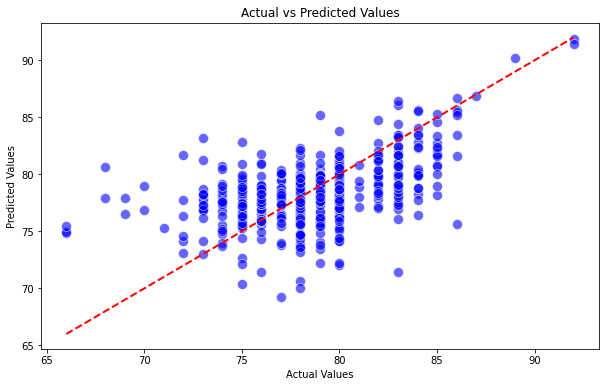

In [183]:
import xgboost as xgb

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Make predictions
y_pred = xgb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
acc = 100*(1-rmse/40)
print(f'R-squared: {r2}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'Accuracy 100*(1-rmse/40): {acc:.4f}%')

# Create a DataFrame for plotting
data = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', data=data, color='blue', s=100, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()


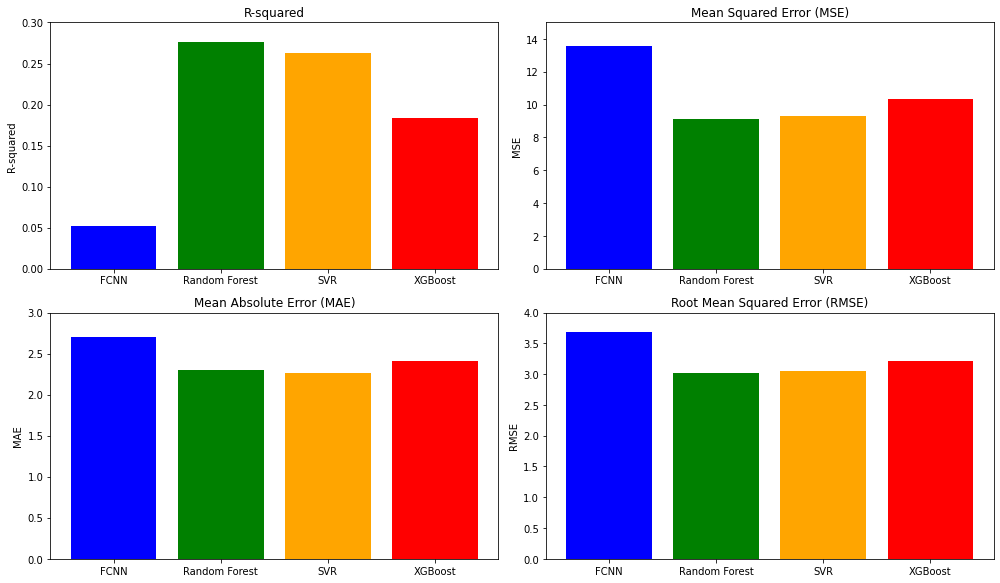

In [202]:
# Metrics for each model
models = ['FCNN', 'Random Forest', 'SVR', 'XGBoost']
r_squared = [0.0518, 0.2766, 0.2625, 0.1841]
mse = [13.5777, 9.1440, 9.3227, 10.3140]
mae = [2.7015, 2.2989, 2.2581, 2.4118] 
rmse = [3.6848, 3.0239, 3.0533, 3.2115]
accuracy = [91.3445, 92.4402, 92.3667, 91.9711]

# Create subplots with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(14, 12))
axs = axs.flatten()  # Flatten the 2D array of axes to make it easier to index

# Bar plot for R-squared
axs[0].bar(models, r_squared, color=['blue', 'green', 'orange', 'red'])
axs[0].set_title('R-squared')
axs[0].set_ylabel('R-squared')
axs[0].set_ylim([0, 0.3])  # Set limit for better visualization

# Bar plot for MSE
axs[1].bar(models, mse, color=['blue', 'green', 'orange', 'red'])
axs[1].set_title('Mean Squared Error (MSE)')
axs[1].set_ylabel('MSE')
axs[1].set_ylim([0, 15])  # Set limit for better visualization

# Bar plot for MAE
if not all(np.isnan(mae)):  # Check if there is any MAE data to plot
    axs[2].bar(models, [m if not np.isnan(m) else 0 for m in mae], color=['blue', 'green', 'orange', 'red'])
    axs[2].set_title('Mean Absolute Error (MAE)')
    axs[2].set_ylabel('MAE')
    axs[2].set_ylim([0, 3])  # Set limit for better visualization
else:
    axs[2].remove()  # Remove the subplot if there is no MAE data

# Bar plot for RMSE
axs[3].bar(models, rmse, color=['blue', 'green', 'orange', 'red'])
axs[3].set_title('Root Mean Squared Error (RMSE)')
axs[3].set_ylabel('RMSE')
axs[3].set_ylim([0, 4])  # Set limit for better visualization

# Bar plot for Accuracy
if not all(np.isnan(accuracy)):  # Check if there is any accuracy data to plot
    axs[4].bar(models, [a if not np.isnan(a) else 0 for a in accuracy], color=['blue', 'green', 'orange', 'red'])
    axs[4].set_title('Accuracy 100*(1-rmse/40)')
    axs[4].set_ylabel('Accuracy (%)')
    axs[4].set_ylim([80, 90])  # Set limit for better visualization
else:
    axs[4].remove()  # Remove the subplot if there is no accuracy data

# Hide any remaining empty subplots
for i in range(len(models), len(axs)):
    axs[i].remove()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

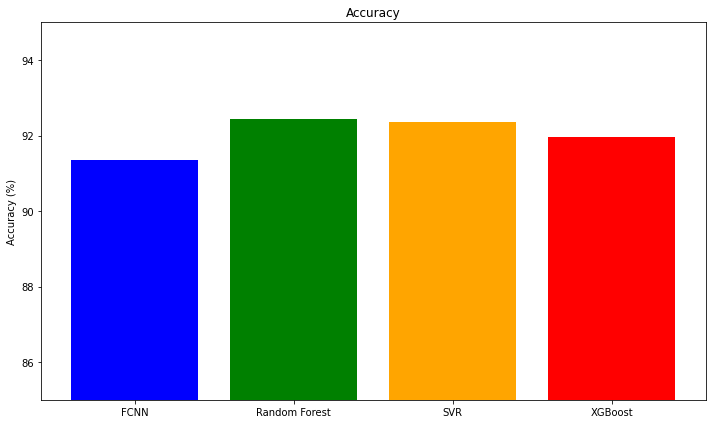

In [200]:
# Create a single subplot
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for Accuracy
if not all(np.isnan(accuracy)):  # Check if there is any accuracy data to plot
    ax.bar(models, [a if not np.isnan(a) else 0 for a in accuracy], color=['blue', 'green', 'orange', 'red'])
    ax.set_title('Accuracy')
    ax.set_ylabel('Accuracy (%)')
    ax.set_ylim([85, 95])  # Set limit for better visualization
else:
    ax.text(0.5, 0.5, 'No Accuracy Data Available', fontsize=14, ha='center', va='center')

# Show the plot
plt.tight_layout()
plt.show()